## 1. Import Libraries

In [1]:
# Standard libraries
import os
import sys
import json
from pathlib import Path
from typing import Dict, List, Tuple, Optional

# Data handling
import numpy as np
import pandas as pd

# Image processing
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Progress tracking
from tqdm.auto import tqdm

# Deep learning
import torch
import torch.nn.functional as F
from torchvision import transforms

# Configuration
import yaml

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)
plt.rcParams['font.size'] = 10

print("✅ Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

✅ Libraries imported successfully!
PyTorch version: 2.7.1+cu118
CUDA available: True
GPU: NVIDIA GeForce MX450


## 2. Setup Paths and Load Previous Utilities

In [2]:
# Project paths
project_root = Path(r'd:\Projects\AI-Virtual-TryOn')
dataset_root = project_root / 'data' / 'zalando-hd-resized'
processed_dir = project_root / 'data' / 'processed'
output_dir = project_root / 'outputs' / 'cloth_agnostic'
output_dir.mkdir(parents=True, exist_ok=True)

print(f"📁 Project Root: {project_root}")
print(f"📁 Dataset Root: {dataset_root}")
print(f"📁 Processed Data: {processed_dir}")
print(f"📁 Output Directory: {output_dir}")

# Load preprocessing configuration
config_path = processed_dir / 'preprocessing_config.yaml'
with open(config_path, 'r') as f:
    preprocess_config = yaml.load(f, Loader=yaml.FullLoader)

print("\n✅ Loaded preprocessing configuration")

# Device configuration
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\n🖥️ Using device: {device}")

# Load dataset catalogs
train_catalog = pd.read_csv(processed_dir / 'train_catalog.csv')
val_catalog = pd.read_csv(processed_dir / 'val_catalog.csv')
test_catalog = pd.read_csv(processed_dir / 'test_catalog.csv')

print(f"\n📊 Dataset loaded: {len(train_catalog)} train, {len(val_catalog)} val, {len(test_catalog)} test")

📁 Project Root: d:\Projects\AI-Virtual-TryOn
📁 Dataset Root: d:\Projects\AI-Virtual-TryOn\data\zalando-hd-resized
📁 Processed Data: d:\Projects\AI-Virtual-TryOn\data\processed
📁 Output Directory: d:\Projects\AI-Virtual-TryOn\outputs\cloth_agnostic

✅ Loaded preprocessing configuration

🖥️ Using device: cuda

📊 Dataset loaded: 10482 train, 1165 val, 2032 test


## 3. Load Parsing and Pose Utilities

Import the utilities we created in previous notebooks.

In [3]:
# LIP parsing classes (from notebook 04)
LIP_CLASSES = {
    0: 'Background',
    1: 'Hat',
    2: 'Hair',
    3: 'Glove',
    4: 'Sunglasses',
    5: 'Upper-clothes',
    6: 'Dress',
    7: 'Coat',
    8: 'Socks',
    9: 'Pants',
    10: 'Jumpsuits',
    11: 'Scarf',
    12: 'Skirt',
    13: 'Face',
    14: 'Left-arm',
    15: 'Right-arm',
    16: 'Left-leg',
    17: 'Right-leg',
    18: 'Left-shoe',
    19: 'Right-shoe'
}

# Garment classes
GARMENT_CLASSES = {
    'upper_body': [5, 7],      # Upper-clothes, Coat
    'lower_body': [9, 12],     # Pants, Skirt
    'full_body': [6, 10],      # Dress, Jumpsuits
    'accessories': [1, 3, 4, 8, 11, 18, 19]  # Hat, Glove, Sunglasses, Socks, Scarf, Shoes
}

# Body part classes for cloth-agnostic representation
BODY_PARTS = {
    'face': [13],
    'hair': [2],
    'arms': [14, 15],
    'legs': [16, 17],
    'background': [0]
}

# OpenPose keypoint structure (from notebook 05)
BODY25_KEYPOINTS = {
    0: 'Nose', 1: 'Neck', 2: 'RShoulder', 3: 'RElbow', 4: 'RWrist',
    5: 'LShoulder', 6: 'LElbow', 7: 'LWrist', 8: 'MidHip',
    9: 'RHip', 10: 'RKnee', 11: 'RAnkle',
    12: 'LHip', 13: 'LKnee', 14: 'LAnkle',
    15: 'REye', 16: 'LEye', 17: 'REar', 18: 'LEar',
    19: 'LBigToe', 20: 'LSmallToe', 21: 'LHeel',
    22: 'RBigToe', 23: 'RSmallToe', 24: 'RHeel'
}

print("✅ Parsing and pose structures loaded")
print(f"   - LIP classes: {len(LIP_CLASSES)}")
print(f"   - Garment categories: {len(GARMENT_CLASSES)}")
print(f"   - Body parts: {len(BODY_PARTS)}")
print(f"   - Pose keypoints: {len(BODY25_KEYPOINTS)}")

✅ Parsing and pose structures loaded
   - LIP classes: 20
   - Garment categories: 4
   - Body parts: 5
   - Pose keypoints: 25


## 4. Cloth-Agnostic Mask Generation

Create mask that represents the person with target garment removed.

In [4]:
def create_cloth_agnostic_mask(parsing: np.ndarray, 
                               garment_type: str = 'upper_body') -> np.ndarray:
    """
    Create cloth-agnostic mask by removing target garment region.
    
    Args:
        parsing: [H, W] parsing mask with class indices
        garment_type: 'upper_body', 'lower_body', or 'full_body'
    
    Returns:
        Binary mask [H, W] where 1 = keep, 0 = remove
    """
    mask = np.ones_like(parsing, dtype=np.uint8)
    
    # Get garment class IDs to remove
    classes_to_remove = GARMENT_CLASSES.get(garment_type, [])
    
    # Remove garment regions
    for cls_id in classes_to_remove:
        mask[parsing == cls_id] = 0
    
    return mask


def get_body_parts_mask(parsing: np.ndarray, include_parts: List[str]) -> np.ndarray:
    """
    Extract specific body parts from parsing mask.
    
    Args:
        parsing: [H, W] parsing mask
        include_parts: List of body part names to include
    
    Returns:
        Binary mask [H, W]
    """
    mask = np.zeros_like(parsing, dtype=np.uint8)
    
    for part_name in include_parts:
        if part_name in BODY_PARTS:
            class_ids = BODY_PARTS[part_name]
            for cls_id in class_ids:
                mask[parsing == cls_id] = 1
    
    return mask


def create_cloth_agnostic_rgb(person_img: np.ndarray, 
                              parsing: np.ndarray,
                              garment_type: str = 'upper_body',
                              fill_color: Tuple[int, int, int] = (128, 128, 128)) -> np.ndarray:
    """
    Create cloth-agnostic RGB representation.
    
    Args:
        person_img: [H, W, 3] RGB image
        parsing: [H, W] parsing mask
        garment_type: Type of garment to remove
        fill_color: Color to fill removed regions
    
    Returns:
        RGB image [H, W, 3] with garment region filled
    """
    # Create cloth-agnostic mask
    ca_mask = create_cloth_agnostic_mask(parsing, garment_type)
    
    # Apply mask to image
    result = person_img.copy()
    result[ca_mask == 0] = fill_color
    
    return result


print("✅ Cloth-agnostic generation functions created")

✅ Cloth-agnostic generation functions created


## 5. Pose Heatmap Generation

Convert OpenPose keypoints to Gaussian heatmaps.

In [5]:
def load_pose_keypoints(json_path: str) -> np.ndarray:
    """
    Load pose keypoints from OpenPose JSON file.
    
    Returns:
        Array of shape [25, 3] with (x, y, confidence)
    """
    with open(json_path, 'r') as f:
        data = json.load(f)
    
    if 'people' in data and len(data['people']) > 0:
        pose_keypoints = data['people'][0]['pose_keypoints_2d']
        keypoints = np.array(pose_keypoints).reshape(-1, 3)
        return keypoints
    else:
        return np.zeros((25, 3))


def create_pose_heatmaps(keypoints: np.ndarray, 
                        image_size: Tuple[int, int],
                        sigma: float = 3.0,
                        threshold: float = 0.1) -> np.ndarray:
    """
    Create Gaussian heatmaps for pose keypoints.
    
    Args:
        keypoints: [25, 3] array of (x, y, confidence)
        image_size: (height, width)
        sigma: Gaussian kernel size
        threshold: Confidence threshold
    
    Returns:
        Heatmaps [25, H, W]
    """
    h, w = image_size
    heatmaps = np.zeros((25, h, w), dtype=np.float32)
    
    # Create coordinate grids
    y_grid, x_grid = np.ogrid[:h, :w]
    
    for i, (x, y, conf) in enumerate(keypoints):
        if conf > threshold:
            x, y = int(x), int(y)
            if 0 <= x < w and 0 <= y < h:
                # Gaussian heatmap
                heatmap = np.exp(-((x_grid - x)**2 + (y_grid - y)**2) / (2 * sigma**2))
                heatmaps[i] = heatmap * conf
    
    return heatmaps


def visualize_pose_heatmap(heatmaps: np.ndarray, method: str = 'max') -> np.ndarray:
    """
    Visualize pose heatmaps as single image.
    
    Args:
        heatmaps: [25, H, W] or [18, H, W]
        method: 'max' (max pooling) or 'mean' (average)
    
    Returns:
        Single channel visualization [H, W]
    """
    if method == 'max':
        return np.max(heatmaps, axis=0)
    elif method == 'mean':
        return np.mean(heatmaps, axis=0)
    else:
        return np.sum(heatmaps, axis=0)


print("✅ Pose heatmap generation functions created")

✅ Pose heatmap generation functions created


## 6. Visualize Single Sample - Complete Pipeline

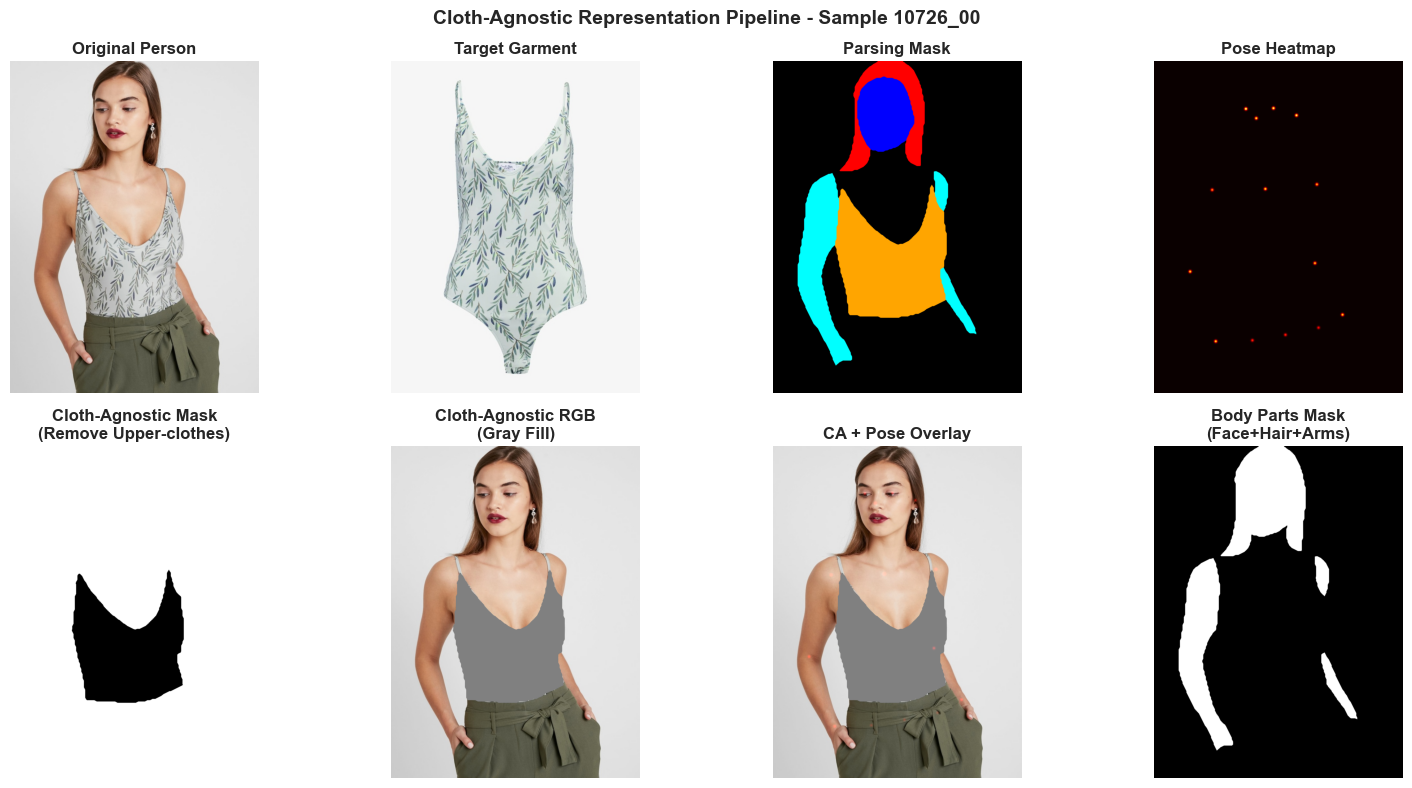

✅ Pipeline visualization saved

📊 Data shapes:
   Person image: (1024, 768, 3)
   Parsing mask: (1024, 768)
   Pose heatmaps: (25, 1024, 768)
   CA mask: (1024, 768)
   CA RGB: (1024, 768, 3)


In [6]:
# Load a sample
sample_idx = 0
sample_row = train_catalog.iloc[sample_idx]

# Load all data
person_img = np.array(Image.open(sample_row['person_image']))
cloth_img = np.array(Image.open(sample_row['cloth_image']))
parsing = np.array(Image.open(sample_row['parse_mask']))
keypoints = load_pose_keypoints(sample_row['pose_json'])

# Generate representations
ca_mask = create_cloth_agnostic_mask(parsing, 'upper_body')
ca_rgb = create_cloth_agnostic_rgb(person_img, parsing, 'upper_body')
pose_heatmaps = create_pose_heatmaps(keypoints, person_img.shape[:2])
pose_viz = visualize_pose_heatmap(pose_heatmaps, 'max')

# Create comprehensive visualization
fig, axes = plt.subplots(2, 4, figsize=(16, 8))

# Row 1: Input data
axes[0, 0].imshow(person_img)
axes[0, 0].set_title('Original Person', fontweight='bold')
axes[0, 0].axis('off')

axes[0, 1].imshow(cloth_img)
axes[0, 1].set_title('Target Garment', fontweight='bold')
axes[0, 1].axis('off')

# Color-coded parsing
colored_parsing = np.zeros((*parsing.shape, 3), dtype=np.uint8)
colored_parsing[parsing == 2] = [255, 0, 0]      # Hair - Red
colored_parsing[parsing == 13] = [0, 0, 255]     # Face - Blue
colored_parsing[parsing == 5] = [255, 165, 0]    # Upper-clothes - Orange
colored_parsing[parsing == 14] = [0, 255, 255]   # Left-arm - Cyan
colored_parsing[parsing == 15] = [0, 255, 255]   # Right-arm - Cyan
colored_parsing[parsing == 9] = [0, 255, 0]      # Pants - Green

axes[0, 2].imshow(colored_parsing)
axes[0, 2].set_title('Parsing Mask', fontweight='bold')
axes[0, 2].axis('off')

axes[0, 3].imshow(pose_viz, cmap='hot')
axes[0, 3].set_title('Pose Heatmap', fontweight='bold')
axes[0, 3].axis('off')

# Row 2: Generated representations
axes[1, 0].imshow(ca_mask, cmap='gray')
axes[1, 0].set_title('Cloth-Agnostic Mask\n(Remove Upper-clothes)', fontweight='bold')
axes[1, 0].axis('off')

axes[1, 1].imshow(ca_rgb)
axes[1, 1].set_title('Cloth-Agnostic RGB\n(Gray Fill)', fontweight='bold')
axes[1, 1].axis('off')

# Overlay pose on cloth-agnostic
overlay = ca_rgb.copy()
pose_colored = (pose_viz[:, :, np.newaxis] * np.array([255, 0, 0])).astype(np.uint8)
overlay = np.clip(overlay.astype(float) + pose_colored.astype(float) * 0.5, 0, 255).astype(np.uint8)
axes[1, 2].imshow(overlay)
axes[1, 2].set_title('CA + Pose Overlay', fontweight='bold')
axes[1, 2].axis('off')

# Show body parts mask
body_mask = get_body_parts_mask(parsing, ['face', 'hair', 'arms'])
axes[1, 3].imshow(body_mask, cmap='gray')
axes[1, 3].set_title('Body Parts Mask\n(Face+Hair+Arms)', fontweight='bold')
axes[1, 3].axis('off')

plt.suptitle(f'Cloth-Agnostic Representation Pipeline - Sample {sample_row["id"]}', 
             fontsize=14, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig(output_dir / 'cloth_agnostic_pipeline.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"✅ Pipeline visualization saved")
print(f"\n📊 Data shapes:")
print(f"   Person image: {person_img.shape}")
print(f"   Parsing mask: {parsing.shape}")
print(f"   Pose heatmaps: {pose_heatmaps.shape}")
print(f"   CA mask: {ca_mask.shape}")
print(f"   CA RGB: {ca_rgb.shape}")

## 7. Generate Multiple Samples

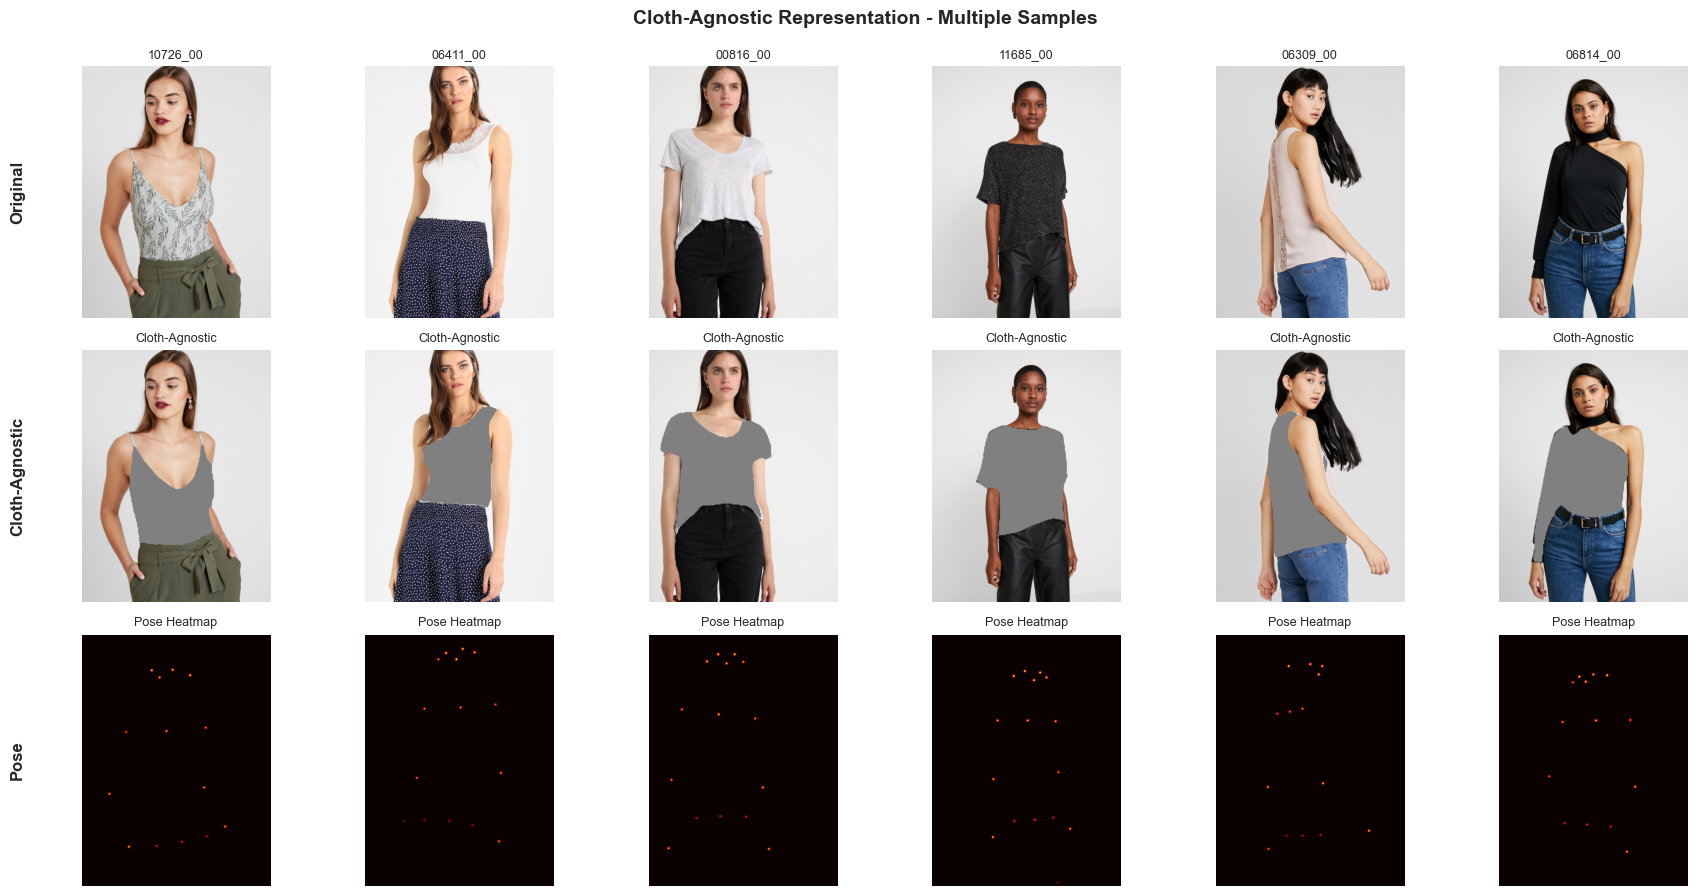

✅ Multiple samples visualization saved


In [7]:
# Generate 6 samples
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for i in range(6):
    sample_row = train_catalog.iloc[i * 20]
    
    # Load data
    person_img = np.array(Image.open(sample_row['person_image']))
    parsing = np.array(Image.open(sample_row['parse_mask']))
    keypoints = load_pose_keypoints(sample_row['pose_json'])
    
    # Generate representations
    ca_rgb = create_cloth_agnostic_rgb(person_img, parsing, 'upper_body')
    pose_heatmaps = create_pose_heatmaps(keypoints, person_img.shape[:2])
    pose_viz = visualize_pose_heatmap(pose_heatmaps, 'max')
    
    # Plot
    axes[0, i].imshow(person_img)
    axes[0, i].set_title(f'{sample_row["id"]}', fontsize=9)
    axes[0, i].axis('off')
    
    axes[1, i].imshow(ca_rgb)
    axes[1, i].set_title('Cloth-Agnostic', fontsize=9)
    axes[1, i].axis('off')
    
    axes[2, i].imshow(pose_viz, cmap='hot')
    axes[2, i].set_title('Pose Heatmap', fontsize=9)
    axes[2, i].axis('off')

# Add row labels
axes[0, 0].text(-0.3, 0.5, 'Original', transform=axes[0, 0].transAxes,
                fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
axes[1, 0].text(-0.3, 0.5, 'Cloth-Agnostic', transform=axes[1, 0].transAxes,
                fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)
axes[2, 0].text(-0.3, 0.5, 'Pose', transform=axes[2, 0].transAxes,
                fontsize=12, fontweight='bold', va='center', ha='right', rotation=90)

plt.suptitle('Cloth-Agnostic Representation - Multiple Samples', 
             fontsize=14, fontweight='bold', y=0.99)
plt.tight_layout()
plt.savefig(output_dir / 'cloth_agnostic_samples.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Multiple samples visualization saved")

## 8. Multi-Channel Input Generation

Combine all representations into final model input.

In [8]:
class MultiChannelInputGenerator:
    """
    Generate multi-channel input for virtual try-on model.
    
    Input format:
    - Cloth-agnostic RGB: 3 channels
    - Pose heatmaps: 18 channels (Body25 reduced to 18)
    - Parsing one-hot: 20 channels
    Total: 41 channels
    """
    
    def __init__(self, image_size: Tuple[int, int] = (1024, 768)):
        self.image_size = image_size  # (H, W)
        self.num_parsing_classes = 20
        self.num_pose_channels = 18  # OpenPose BODY_18 format
        
        # Mapping from Body25 (25 keypoints) to Body18 (18 keypoints)
        # We'll use the first 18 keypoints and skip foot details
        self.body25_to_18 = list(range(18))  # Use keypoints 0-17
    
    def parsing_to_onehot(self, parsing: np.ndarray) -> np.ndarray:
        """
        Convert parsing mask to one-hot encoding.
        
        Args:
            parsing: [H, W] with class indices
        
        Returns:
            One-hot array [20, H, W]
        """
        h, w = parsing.shape
        onehot = np.zeros((self.num_parsing_classes, h, w), dtype=np.float32)
        
        for i in range(self.num_parsing_classes):
            onehot[i][parsing == i] = 1.0
        
        return onehot
    
    def reduce_pose_to_18_channels(self, pose_25: np.ndarray) -> np.ndarray:
        """
        Reduce 25-channel pose to 18-channel (skip foot keypoints).
        
        Args:
            pose_25: [25, H, W]
        
        Returns:
            Reduced pose [18, H, W]
        """
        return pose_25[:18]  # Take first 18 channels
    
    def generate_input(self, 
                      person_img: np.ndarray,
                      parsing: np.ndarray,
                      keypoints: np.ndarray,
                      garment_type: str = 'upper_body',
                      normalize: bool = True) -> Dict[str, np.ndarray]:
        """
        Generate all input representations.
        
        Returns:
            Dictionary with all representations
        """
        # 1. Cloth-agnostic RGB (3 channels)
        ca_rgb = create_cloth_agnostic_rgb(person_img, parsing, garment_type)
        if normalize:
            ca_rgb = (ca_rgb.astype(np.float32) / 255.0 - 0.5) / 0.5  # Normalize to [-1, 1]
        ca_rgb = np.transpose(ca_rgb, (2, 0, 1))  # [3, H, W]
        
        # 2. Pose heatmaps (18 channels)
        pose_25 = create_pose_heatmaps(keypoints, self.image_size)
        pose_18 = self.reduce_pose_to_18_channels(pose_25)  # [18, H, W]
        
        # 3. Parsing one-hot (20 channels)
        parsing_onehot = self.parsing_to_onehot(parsing)  # [20, H, W]
        
        # 4. Cloth-agnostic mask (1 channel)
        ca_mask = create_cloth_agnostic_mask(parsing, garment_type)
        ca_mask = ca_mask[np.newaxis, :, :]  # [1, H, W]
        
        # 5. Combined input (41 channels: 3 + 18 + 20)
        combined = np.concatenate([ca_rgb, pose_18, parsing_onehot], axis=0)
        
        return {
            'cloth_agnostic_rgb': ca_rgb,        # [3, H, W]
            'pose_heatmaps': pose_18,             # [18, H, W]
            'parsing_onehot': parsing_onehot,     # [20, H, W]
            'cloth_agnostic_mask': ca_mask,       # [1, H, W]
            'combined_input': combined             # [41, H, W]
        }
    
    def to_tensor(self, data: np.ndarray) -> torch.Tensor:
        """
        Convert numpy array to PyTorch tensor.
        """
        return torch.from_numpy(data).float()


# Test the generator
generator = MultiChannelInputGenerator(image_size=(1024, 768))

sample_row = train_catalog.iloc[0]
person_img = np.array(Image.open(sample_row['person_image']))
parsing = np.array(Image.open(sample_row['parse_mask']))
keypoints = load_pose_keypoints(sample_row['pose_json'])

inputs = generator.generate_input(person_img, parsing, keypoints)

print("✅ Multi-channel input generator created and tested")
print(f"\n📊 Generated representations:")
for key, value in inputs.items():
    print(f"   {key:25s}: {value.shape}")

print(f"\n💡 Total input channels: {inputs['combined_input'].shape[0]}")
print(f"   - Cloth-agnostic RGB: 3")
print(f"   - Pose heatmaps: 18")
print(f"   - Parsing one-hot: 20")

✅ Multi-channel input generator created and tested

📊 Generated representations:
   cloth_agnostic_rgb       : (3, 1024, 768)
   pose_heatmaps            : (18, 1024, 768)
   parsing_onehot           : (20, 1024, 768)
   cloth_agnostic_mask      : (1, 1024, 768)
   combined_input           : (41, 1024, 768)

💡 Total input channels: 41
   - Cloth-agnostic RGB: 3
   - Pose heatmaps: 18
   - Parsing one-hot: 20


## 9. Visualize Multi-Channel Input

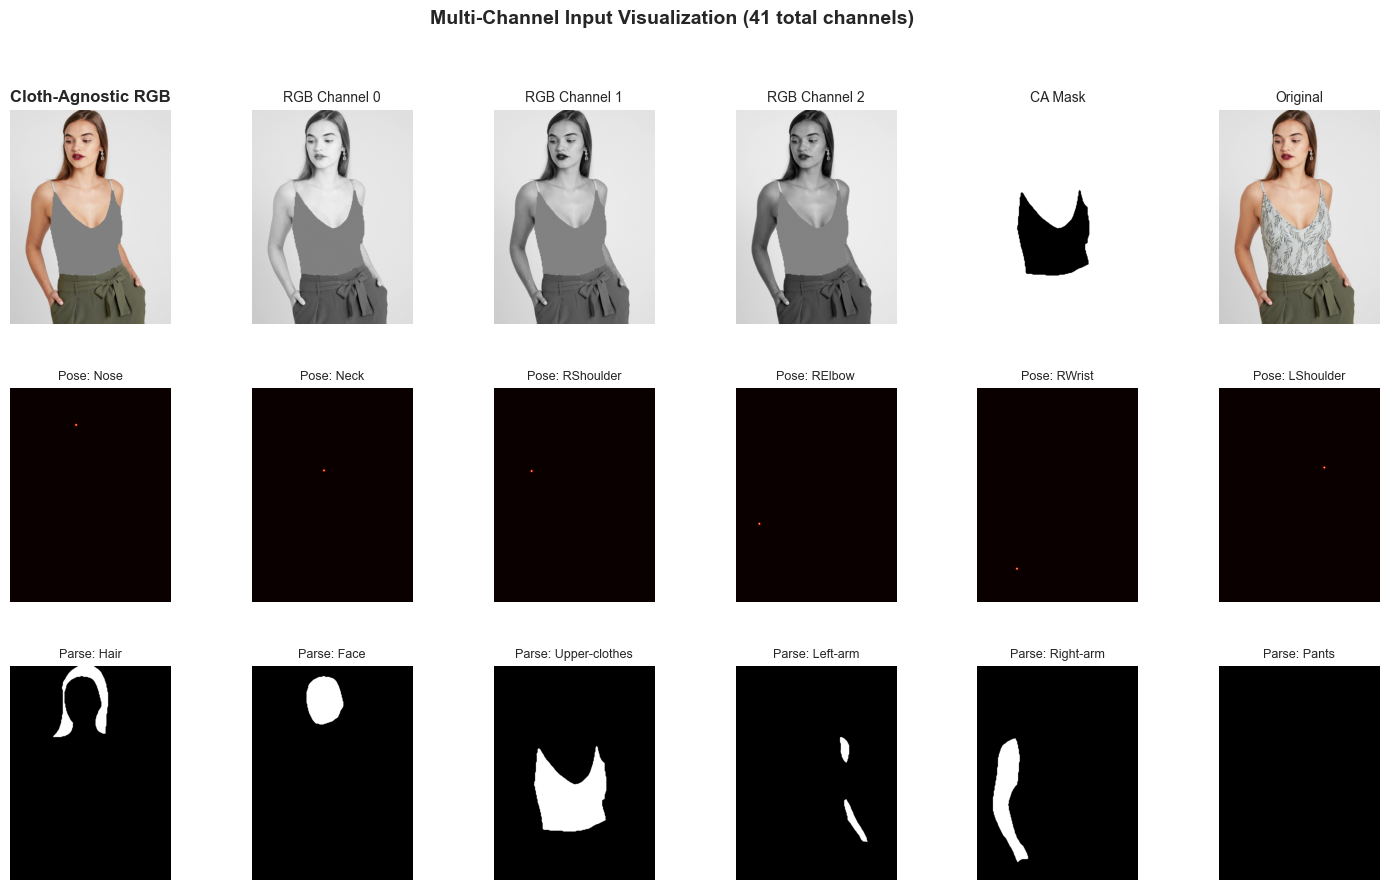

✅ Multi-channel visualization saved


In [9]:
# Visualize different channels
fig = plt.figure(figsize=(18, 10))
gs = fig.add_gridspec(3, 6, hspace=0.3, wspace=0.3)

# Row 1: RGB channels
ax1 = fig.add_subplot(gs[0, 0])
ca_rgb_vis = np.transpose(inputs['cloth_agnostic_rgb'], (1, 2, 0))  # [H, W, 3]
ca_rgb_vis = ((ca_rgb_vis * 0.5 + 0.5) * 255).astype(np.uint8)  # Denormalize
ax1.imshow(ca_rgb_vis)
ax1.set_title('Cloth-Agnostic RGB', fontweight='bold')
ax1.axis('off')

for i in range(3):
    ax = fig.add_subplot(gs[0, i+1])
    ax.imshow(inputs['cloth_agnostic_rgb'][i], cmap='gray')
    ax.set_title(f'RGB Channel {i}', fontsize=10)
    ax.axis('off')

# Show CA mask
ax = fig.add_subplot(gs[0, 4])
ax.imshow(inputs['cloth_agnostic_mask'][0], cmap='gray')
ax.set_title('CA Mask', fontsize=10)
ax.axis('off')

# Original for reference
ax = fig.add_subplot(gs[0, 5])
ax.imshow(person_img)
ax.set_title('Original', fontsize=10)
ax.axis('off')

# Row 2: Some pose channels
pose_channels_to_show = [0, 1, 2, 3, 4, 5]  # Nose, Neck, Shoulders, Elbows
for i, ch_idx in enumerate(pose_channels_to_show):
    ax = fig.add_subplot(gs[1, i])
    ax.imshow(inputs['pose_heatmaps'][ch_idx], cmap='hot')
    keypoint_name = BODY25_KEYPOINTS.get(ch_idx, f'KP-{ch_idx}')
    ax.set_title(f'Pose: {keypoint_name}', fontsize=9)
    ax.axis('off')

# Row 3: Some parsing channels
parsing_channels = [2, 13, 5, 14, 15, 9]  # Hair, Face, Upper-clothes, Arms, Pants
for i, ch_idx in enumerate(parsing_channels):
    ax = fig.add_subplot(gs[2, i])
    ax.imshow(inputs['parsing_onehot'][ch_idx], cmap='gray')
    class_name = LIP_CLASSES.get(ch_idx, f'Class-{ch_idx}')
    ax.set_title(f'Parse: {class_name}', fontsize=9)
    ax.axis('off')

plt.suptitle('Multi-Channel Input Visualization (41 total channels)', 
             fontsize=14, fontweight='bold')
plt.savefig(output_dir / 'multi_channel_input.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Multi-channel visualization saved")

## 10. Quality Assessment

In [10]:
def assess_cloth_agnostic_quality(ca_mask: np.ndarray, parsing: np.ndarray) -> Dict:
    """
    Assess quality of cloth-agnostic generation.
    """
    quality = {
        'removed_pixels': int((ca_mask == 0).sum()),
        'removed_percentage': float((ca_mask == 0).sum() / ca_mask.size * 100),
        'kept_pixels': int((ca_mask == 1).sum()),
        'kept_percentage': float((ca_mask == 1).sum() / ca_mask.size * 100),
        'has_face': bool((parsing == 13).any()),
        'has_arms': bool((parsing == 14).any() or (parsing == 15).any()),
        'status': 'good'
    }
    
    # Check if reasonable amount removed (5-30%)
    if quality['removed_percentage'] < 5 or quality['removed_percentage'] > 50:
        quality['status'] = 'warning'
    
    return quality


# Assess 200 samples
print("="*70)
print("🎯 CLOTH-AGNOSTIC QUALITY ASSESSMENT")
print("="*70)

n_assess = 200
samples = train_catalog.iloc[:n_assess]

stats = {
    'removed_percentages': [],
    'has_face': 0,
    'has_arms': 0,
    'good': 0,
    'warning': 0
}

print(f"🔍 Assessing {n_assess} cloth-agnostic generations...\n")

for idx, row in tqdm(samples.iterrows(), total=len(samples), desc="Quality check"):
    parsing = np.array(Image.open(row['parse_mask']))
    ca_mask = create_cloth_agnostic_mask(parsing, 'upper_body')
    
    quality = assess_cloth_agnostic_quality(ca_mask, parsing)
    
    stats['removed_percentages'].append(quality['removed_percentage'])
    if quality['has_face']:
        stats['has_face'] += 1
    if quality['has_arms']:
        stats['has_arms'] += 1
    stats[quality['status']] += 1

# Calculate statistics
removed_arr = np.array(stats['removed_percentages'])

print(f"\n📊 Quality Report:")
print("-" * 50)
print(f"✅ Good generations        : {stats['good']:4d} ({stats['good']/n_assess*100:5.1f}%)")
print(f"⚠️ Warnings                : {stats['warning']:4d} ({stats['warning']/n_assess*100:5.1f}%)")

print(f"\n📊 Removed Region Statistics:")
print("-" * 50)
print(f"   Mean removed: {removed_arr.mean():.1f}%")
print(f"   Std removed: {removed_arr.std():.1f}%")
print(f"   Min removed: {removed_arr.min():.1f}%")
print(f"   Max removed: {removed_arr.max():.1f}%")

print(f"\n📊 Body Parts Preserved:")
print("-" * 50)
print(f"✅ Face preserved          : {stats['has_face']:4d} ({stats['has_face']/n_assess*100:5.1f}%)")
print(f"✅ Arms preserved          : {stats['has_arms']:4d} ({stats['has_arms']/n_assess*100:5.1f}%)")

print("\n" + "="*70)

if stats['good'] / n_assess > 0.9:
    print("\n✅ Cloth-agnostic generation quality is excellent!")
else:
    print("\n⚠️ Some samples may need manual review")

🎯 CLOTH-AGNOSTIC QUALITY ASSESSMENT
🔍 Assessing 200 cloth-agnostic generations...



Quality check:   0%|          | 0/200 [00:00<?, ?it/s]


📊 Quality Report:
--------------------------------------------------
✅ Good generations        :  196 ( 98.0%)
⚠️ Warnings                :    4 (  2.0%)

📊 Removed Region Statistics:
--------------------------------------------------
   Mean removed: 17.9%
   Std removed: 7.2%
   Min removed: 0.0%
   Max removed: 37.1%

📊 Body Parts Preserved:
--------------------------------------------------
✅ Face preserved          :  200 (100.0%)
✅ Arms preserved          :  198 ( 99.0%)


✅ Cloth-agnostic generation quality is excellent!


## 11. Save Configuration

In [11]:
# Create cloth-agnostic configuration
ca_config = {
    'image_size': list(generator.image_size),
    'input_channels': {
        'cloth_agnostic_rgb': 3,
        'pose_heatmaps': 18,
        'parsing_onehot': 20,
        'total': 41
    },
    'garment_types': list(GARMENT_CLASSES.keys()),
    'body_parts': list(BODY_PARTS.keys()),
    'fill_color': [128, 128, 128],
    'pose_sigma': 3.0,
    'pose_threshold': 0.1,
    'normalization': {
        'rgb_mean': 0.5,
        'rgb_std': 0.5,
        'range': [-1, 1]
    },
    'quality_stats': {
        'samples_assessed': n_assess,
        'good_percentage': stats['good'] / n_assess * 100,
        'mean_removed': float(removed_arr.mean()),
        'std_removed': float(removed_arr.std())
    }
}

config_path = output_dir / 'cloth_agnostic_config.json'
with open(config_path, 'w') as f:
    json.dump(ca_config, f, indent=2)

print("="*70)
print("💾 CLOTH-AGNOSTIC CONFIGURATION SAVED")
print("="*70)

print(f"\n📄 Config saved to: {config_path}")

print(f"\n📊 Configuration Summary:")
print(f"   - Image size: {ca_config['image_size']}")
print(f"   - Total input channels: {ca_config['input_channels']['total']}")
print(f"   - Garment types: {len(ca_config['garment_types'])}")
print(f"   - Quality: {ca_config['quality_stats']['good_percentage']:.1f}% good")

print("\n" + "="*70)

💾 CLOTH-AGNOSTIC CONFIGURATION SAVED

📄 Config saved to: d:\Projects\AI-Virtual-TryOn\outputs\cloth_agnostic\cloth_agnostic_config.json

📊 Configuration Summary:
   - Image size: [1024, 768]
   - Total input channels: 41
   - Garment types: 4
   - Quality: 98.0% good



## 12. Summary and Next Steps

In [12]:
print("="*70)
print("🎉 CLOTH-AGNOSTIC REPRESENTATION COMPLETE!")
print("="*70)

print("\n✅ Completed Tasks:")
print("   1. ✓ Created cloth-agnostic mask generation")
print("   2. ✓ Implemented RGB cloth-agnostic representation")
print("   3. ✓ Generated pose heatmaps (18 channels)")
print("   4. ✓ Created parsing one-hot encoding (20 channels)")
print("   5. ✓ Built multi-channel input generator (41 channels total)")
print("   6. ✓ Assessed generation quality")
print("   7. ✓ Saved configuration")

print(f"\n📊 Key Findings:")
print(f"   - Input channels: 3 (RGB) + 18 (Pose) + 20 (Parsing) = 41")
print(f"   - Good quality: {stats['good']}/{n_assess} ({stats['good']/n_assess*100:.1f}%)")
print(f"   - Mean garment removal: {removed_arr.mean():.1f}%")
print(f"   - Face preserved: {stats['has_face']/n_assess*100:.1f}%")
print(f"   - Arms preserved: {stats['has_arms']/n_assess*100:.1f}%")

print(f"\n📁 Generated Files:")
print(f"   - cloth_agnostic_pipeline.png")
print(f"   - cloth_agnostic_samples.png")
print(f"   - multi_channel_input.png")
print(f"   - cloth_agnostic_config.json")

print("\n🚀 Ready for Next Steps:")
print("   1. Create PyTorch Dataset class with all preprocessing")
print("   2. Build DataLoader pipeline for training")
print("   3. Begin model architecture development (Generator, Discriminator)")
print("   4. Implement training loop")

print("\n💡 Key Components Created:")
print("   - create_cloth_agnostic_mask(): Remove garment from mask")
print("   - create_cloth_agnostic_rgb(): Generate RGB representation")
print("   - create_pose_heatmaps(): Gaussian heatmaps from keypoints")
print("   - MultiChannelInputGenerator: Complete preprocessing pipeline")
print("     * parsing_to_onehot()")
print("     * reduce_pose_to_18_channels()")
print("     * generate_input()")
print("     * to_tensor()")

print("\n" + "="*70)

print("\n✅ CLOTH-AGNOSTIC MODULE READY!")
print("="*70)

🎉 CLOTH-AGNOSTIC REPRESENTATION COMPLETE!

✅ Completed Tasks:
   1. ✓ Created cloth-agnostic mask generation
   2. ✓ Implemented RGB cloth-agnostic representation
   3. ✓ Generated pose heatmaps (18 channels)
   4. ✓ Created parsing one-hot encoding (20 channels)
   5. ✓ Built multi-channel input generator (41 channels total)
   6. ✓ Assessed generation quality
   7. ✓ Saved configuration

📊 Key Findings:
   - Input channels: 3 (RGB) + 18 (Pose) + 20 (Parsing) = 41
   - Good quality: 196/200 (98.0%)
   - Mean garment removal: 17.9%
   - Face preserved: 100.0%
   - Arms preserved: 99.0%

📁 Generated Files:
   - cloth_agnostic_pipeline.png
   - cloth_agnostic_samples.png
   - multi_channel_input.png
   - cloth_agnostic_config.json

🚀 Ready for Next Steps:
   1. Create PyTorch Dataset class with all preprocessing
   2. Build DataLoader pipeline for training
   3. Begin model architecture development (Generator, Discriminator)
   4. Implement training loop

💡 Key Components Created:
   - c